In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_json('data.json')

if 'no_literals' in df.columns:
    df = df[df['no_literals'] == False].drop(labels=['no_literals'], axis=1).reset_index(drop=True)

# add zeroshot to all retrieval methods
zeroshot = pd.DataFrame(df[df['nshot'] == 0])
for retrieval_method in df['retrieval_method'].unique():
    if retrieval_method != 'random':
        zeroshot['retrieval_method'] = [retrieval_method] * len(zeroshot)
        df = pd.concat([df, zeroshot])

print(len(df))
print(df['retrieval_method'].value_counts())
assert len(set(df['retrieval_method'].value_counts().to_list())) == 1
df = df.sort_values(by=['retrieval_method', 'nshot']).reset_index(drop=True)
df['generation'] = df['generation'].map(lambda i: i.strip())
df.head()

18120
column_jaccard    6040
tfidf             6040
random            6040
Name: retrieval_method, dtype: int64


,question,query,generation,retrieval_method,nshot,masked,precision,recall,f1
0,what is warfarin sodium 2.5 mg po tabs's way o...,select distinct medication.routeadmin from med...,The query extracts all of the patient's medica...,column_jaccard,0,False,0.590455,0.661140,0.623802
1,"what is the method for ingestion of ns 1,000 ml?",select distinct medication.routeadmin from med...,This query selects all the rows from the medic...,column_jaccard,0,False,0.563709,0.675585,0.614598
2,how is atorvastatin calcium 80 mg po tabs taken?,select distinct medication.routeadmin from med...,This query is looking for all medications with...,column_jaccard,0,False,0.653431,0.766081,0.705286
3,what is metoprolol succinate er 50 mg po tb24'...,select distinct medication.routeadmin from med...,This query presents a list of distinct medicat...,column_jaccard,0,False,0.696146,0.752771,0.723352
4,tell me the price of a procedure called agent ...,select distinct cost.cost from cost where cost...,This query will return all of the different co...,column_jaccard,0,False,0.677709,0.668955,0.673304


In [3]:
results = {
    'retrieval_method': [],
    'nshot': [],
    'masked': [],
    'precision': [],
    'recall': [],
    'f1': [],
}

for retrieval_method, dff in df.groupby('retrieval_method'):
    for nshot, dfff in dff.groupby('nshot'):
        for masked, d in dfff.groupby('masked'):
            results['precision'].append(d['precision'].mean())
            results['recall'].append(d['recall'].mean())
            results['f1'].append(d['f1'].mean())
            results['retrieval_method'].append(retrieval_method)
            results['nshot'].append(nshot)
            results['masked'].append(masked)
                
results = pd.DataFrame(results)

results

,retrieval_method,nshot,masked,precision,recall,f1
0,column_jaccard,0,False,0.530106,0.538751,0.532552
1,column_jaccard,0,True,0.499766,0.533410,0.513915
2,column_jaccard,1,False,0.715282,0.703185,0.707719
3,column_jaccard,1,True,0.699129,0.683665,0.689818
4,column_jaccard,2,False,0.748486,0.743061,0.744511
5,column_jaccard,2,True,0.738454,0.728989,0.732314
6,column_jaccard,3,False,0.766526,0.760926,0.762614
7,column_jaccard,3,True,0.760932,0.752195,0.755427
8,random,0,False,0.530106,0.538751,0.532552
9,random,0,True,0.499766,0.533410,0.513915


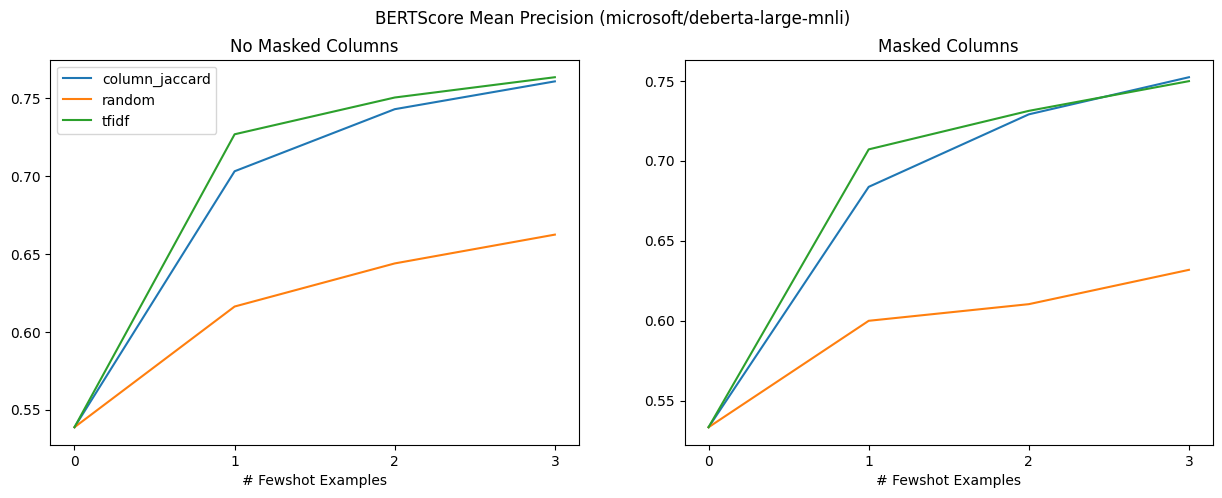

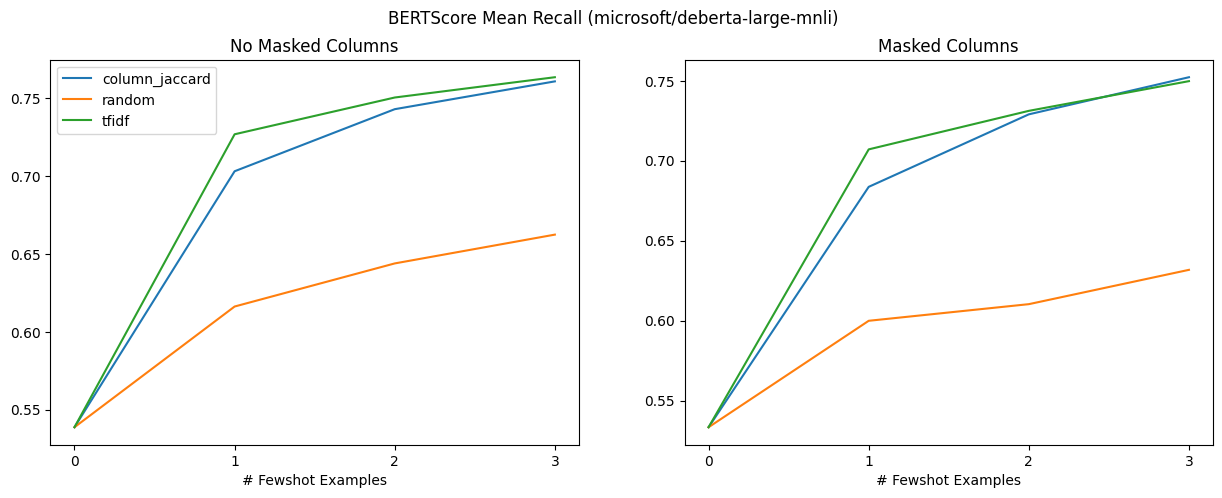

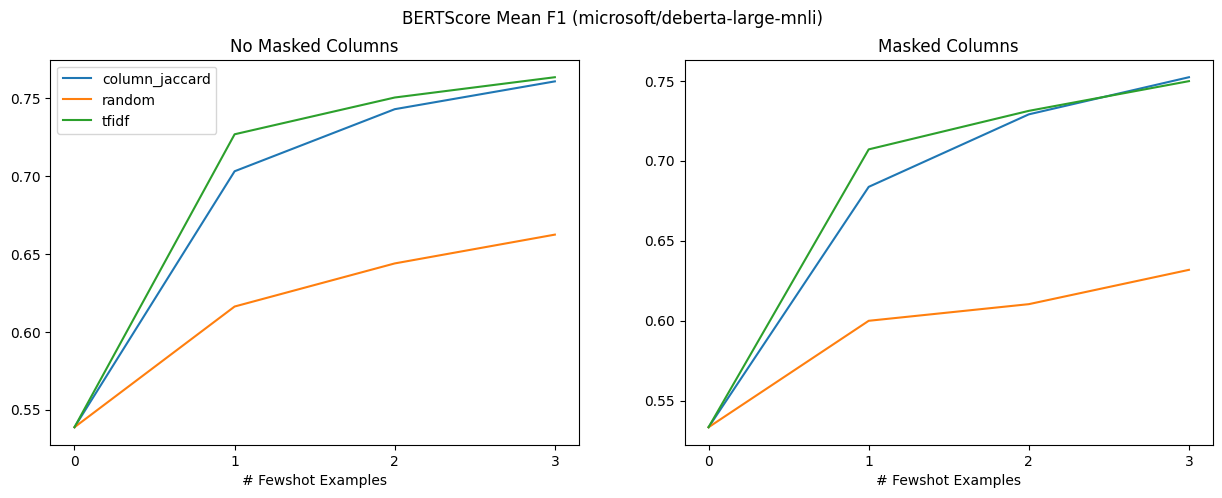

In [4]:
def graph_avg_metric(metric: str):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].title.set_text('No Masked Columns')
    ax[1].title.set_text('Masked Columns')

    for retrieval_method in results['retrieval_method'].unique():
        dff = results[results['retrieval_method'] == retrieval_method]
        with_mask = dff[dff['masked'] == True]
        no_mask = dff[dff['masked'] == False]
        
        ax[0].plot(no_mask['nshot'], no_mask['recall'], label=retrieval_method)
        ax[1].plot(with_mask['nshot'], with_mask['recall'], label=retrieval_method)
        
        for i in range(len(ax)):
            ax[i].set_xticks(list(range(4)))

        ax[0].legend()

        for i in range(2):
            ax[i].set_xlabel('# Fewshot Examples')

    fig.suptitle(f'BERTScore Mean {metric.capitalize()} (microsoft/deberta-large-mnli)')
    plt.savefig(f'images/bertscore-mean-{metric}.png')
    plt.show()

for metric in ['precision', 'recall', 'f1']: 
    graph_avg_metric(metric)

In [5]:
# results[results['retrieval_method'] == 'column_jaccard']

with_mask = results[results['masked'] == True]
no_mask = results[results['masked'] == False]

diffs = with_mask[['retrieval_method', 'nshot']]

for metric in ['precision', 'recall', 'f1']:
    diffs[f'{metric}_diff'] = no_mask[metric].to_numpy() - with_mask[metric].to_numpy()

diffs

/var/folders/dv/vl79wy215j9cf9q7y8n1r4_c0000gn/T/ipykernel_81450/483848091.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diffs[f'{metric}_diff'] = no_mask[metric].to_numpy() - with_mask[metric].to_numpy()
/var/folders/dv/vl79wy215j9cf9q7y8n1r4_c0000gn/T/ipykernel_81450/483848091.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diffs[f'{metric}_diff'] = no_mask[metric].to_numpy() - with_mask[metric].to_numpy()
/var/folders/dv/vl79wy215j9cf9q7y8n1r4_c0000gn/T/ipykernel_81450/483848091.py:9: SettingWi

,retrieval_method,nshot,precision_diff,recall_diff,f1_diff
1,column_jaccard,0,0.030340,0.005341,0.018637
3,column_jaccard,1,0.016153,0.019520,0.017901
5,column_jaccard,2,0.010032,0.014071,0.012196
7,column_jaccard,3,0.005594,0.008731,0.007187
9,random,0,0.030340,0.005341,0.018637
11,random,1,0.019407,0.016349,0.018106
13,random,2,0.025235,0.033642,0.029937
15,random,3,0.028045,0.030689,0.029606
17,tfidf,0,0.030340,0.005341,0.018637
19,tfidf,1,0.014184,0.019852,0.017330
